# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
# import os
# import time
# wait_to_make = "trained_list/double-loss.txt"
# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    
local = True

In [2]:
EXP_NAME = "microsoft-deberta-v3-model-improve"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime
if local:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
else:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'

OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "microsoft/deberta-v3-large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model or "medium" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=8
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig,AutoModelForTokenClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

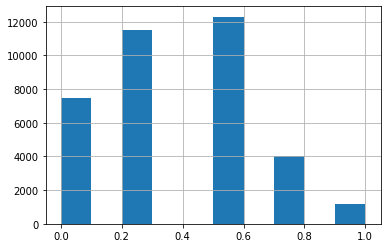

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 133


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
class TransformerHead(nn.Module):
    def __init__(self, in_features, max_length, num_layers=1, nhead=8, num_targets=1):
        super().__init__()

        self.transformer = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=in_features,
                                                                                          nhead=nhead),
                                                 num_layers=num_layers)
        self.row_fc = nn.Linear(in_features, 1)
        self.out_features = max_length

    def forward(self, x):
        out = self.transformer(x)
        out = self.row_fc(out).squeeze(-1)
        return out

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
        
        return output

In [26]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
        
#         # self.feature_extractor = AutoModelForTokenClassification.from_pretrained(OUTPUT_DIR+'extractor/')
#         self.feature_extractor = AutoModelForTokenClassification.from_pretrained(CFG.model,)
#         self.feature_extractor.save_pretrained(OUTPUT_DIR+'extractor/')
#         in_features = self.feature_extractor.classifier.in_features
#         self.attention = TransformerHead(in_features=in_features, max_length=cfg.max_len, num_layers=1, nhead=8, num_targets=1)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.attention.out_features, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         feature = self.attention(last_hidden_states)
        
#         return feature


#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         try:
#             output = self.fc(self.fc_dropout(feature))
#         except Exception as e:
#             print(feature.shape)
#             print(e)
#             exit()
#         return output

# Helpler functions

In [27]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [28]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [ ]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            # if fold in [0,1,2]:
                #continue
               # print（f”￥０r３３［３８；５；４０m＝＝＝＝＝＝＝＝＝＝ this fold is pass ￥ontinue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 1s (remain 72m 11s) Loss: 0.6867(0.6867) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 45s (remain 25m 5s) Loss: 0.6255(0.6426) Grad: 27985.2422  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 30s (remain 24m 6s) Loss: 0.4854(0.6364) Grad: 6571.3467  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 2m 14s (remain 23m 18s) Loss: 0.7282(0.6293) Grad: 29277.8965  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 2m 59s (remain 22m 31s) Loss: 0.6539(0.6159) Grad: 4486.5938  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 3m 44s (remain 21m 46s) Loss: 0.8096(0.6039) Grad: 36914.2617  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 4m 29s (remain 21m 3s) Loss: 0.5455(0.5973) Grad: 15447.0449  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 5m 14s (remain 20m 17s) Loss: 0.5267(0.5919) Grad: 4363.2080  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 5m 58s (remain 19m 32s) Loss: 0.7130(0.5880) Grad: 20659.8730  LR: 0.00001996  
Epoch: [1][900/3419] Elapsed 6m 44s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 42s) Loss: 0.4466(0.4466) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 28s) Loss: 0.5666(0.5536) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 13s) Loss: 0.4760(0.5571) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 59s) Loss: 0.7984(0.5505) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 45s) Loss: 0.4725(0.5493) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 30s) Loss: 0.6013(0.5513) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5546(0.5487) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.6516(0.5494) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.7808(0.5478) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4148(0.5472) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.5300(0.5478) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.5033(0.5480) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 1 - avg_train_loss: 0.5631  avg_val_loss: 0.5479  time: 1714s
Epoch 1 - Score: 0.8204
Epoch 1 - Save Best Score: 0.8204 Model


EVAL: [1139/1140] Elapsed 2m 40s (remain 0m 0s) Loss: 0.6218(0.5479) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 41m 39s) Loss: 0.4586(0.4586) Grad: 151565.1094  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 46s (remain 25m 26s) Loss: 0.4830(0.5347) Grad: 60693.0625  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 1m 32s (remain 24m 37s) Loss: 0.3858(0.5235) Grad: 39142.6289  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 2m 18s (remain 23m 51s) Loss: 0.3523(0.5219) Grad: 23895.3184  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 3m 3s (remain 23m 4s) Loss: 0.5712(0.5185) Grad: 16253.8066  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 3m 49s (remain 22m 18s) Loss: 0.3999(0.5196) Grad: 39408.7617  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 4m 35s (remain 21m 32s) Loss: 0.7279(0.5211) Grad: 127900.5469  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 5m 21s (remain 20m 46s) Loss: 0.6612(0.5196) Grad: 51880.1367  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 6m 7s (remain 20m 0s) Loss: 0.4388(0.5203) Grad: 36957.4414  LR: 0.00001885  
Epoch: [2][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 33s) Loss: 0.4951(0.4951) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.5249(0.5413) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4597(0.5467) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.9003(0.5405) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4781(0.5403) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.5681(0.5423) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5078(0.5396) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.6513(0.5401) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.7871(0.5392) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4418(0.5388) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4835(0.5390) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4831(0.5386) 


Epoch 2 - avg_train_loss: 0.5197  avg_val_loss: 0.5386  time: 1699s
Epoch 2 - Score: 0.8487
Epoch 2 - Save Best Score: 0.8487 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.6127(0.5386) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 43m 34s) Loss: 0.5984(0.5984) Grad: 34580.7852  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 45s (remain 24m 53s) Loss: 0.5914(0.5083) Grad: 177700.7812  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 1m 30s (remain 24m 3s) Loss: 0.4036(0.5080) Grad: 206561.4375  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 2m 14s (remain 23m 16s) Loss: 0.4474(0.5078) Grad: 59905.8984  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 2m 59s (remain 22m 31s) Loss: 0.3529(0.5046) Grad: 19404.0352  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 3m 44s (remain 21m 45s) Loss: 0.4197(0.5015) Grad: 26045.4375  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 4m 28s (remain 21m 0s) Loss: 0.5617(0.5052) Grad: 64197.4766  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 5m 13s (remain 20m 15s) Loss: 0.3723(0.5059) Grad: 57940.4023  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 5m 58s (remain 19m 31s) Loss: 0.5175(0.5067) Grad: 132339.7031  LR: 0.00001639  
Epoch: [3][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 28s) Loss: 0.5694(0.5694) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.5869(0.5435) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4556(0.5413) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.9163(0.5363) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4779(0.5360) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.5672(0.5387) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5257(0.5357) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.6438(0.5376) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8214(0.5376) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4514(0.5368) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4902(0.5373) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4861(0.5370) 


Epoch 3 - avg_train_loss: 0.5077  avg_val_loss: 0.5369  time: 1686s
Epoch 3 - Score: 0.8542
Epoch 3 - Save Best Score: 0.8542 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.6128(0.5369) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 38m 15s) Loss: 0.5681(0.5681) Grad: 59137.3633  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 45s (remain 24m 50s) Loss: 0.3098(0.4807) Grad: 57407.2500  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 1m 30s (remain 24m 1s) Loss: 0.6638(0.4853) Grad: 678160.6875  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 2m 14s (remain 23m 15s) Loss: 0.5014(0.4863) Grad: 147722.6562  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 2m 59s (remain 22m 30s) Loss: 0.6719(0.4932) Grad: 100427.3359  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 3m 44s (remain 21m 45s) Loss: 0.3408(0.4956) Grad: 102076.7188  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 4m 28s (remain 21m 0s) Loss: 0.5103(0.4970) Grad: 73273.1172  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 5m 13s (remain 20m 15s) Loss: 0.5044(0.4953) Grad: 58585.5547  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 5m 58s (remain 19m 30s) Loss: 0.4729(0.4951) Grad: 40875.7617  LR: 0.00001296  
Epoch: [4][900/3419]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 38s) Loss: 0.4767(0.4767) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.5661(0.5481) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4506(0.5524) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 1.0249(0.5484) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4918(0.5482) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.5624(0.5520) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5050(0.5482) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.6277(0.5493) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8269(0.5488) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4437(0.5472) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4884(0.5476) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4670(0.5471) 


Epoch 4 - avg_train_loss: 0.5006  avg_val_loss: 0.5473  time: 1686s
Epoch 4 - Score: 0.8577
Epoch 4 - Save Best Score: 0.8577 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.6093(0.5473) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 46m 16s) Loss: 0.5259(0.5259) Grad: 94589.4531  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 45s (remain 24m 55s) Loss: 0.4799(0.5010) Grad: 480934.0000  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 1m 30s (remain 24m 4s) Loss: 0.6206(0.4918) Grad: 83703.0938  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 2m 14s (remain 23m 17s) Loss: 0.5633(0.4898) Grad: 51138.6992  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 2m 59s (remain 22m 31s) Loss: 0.5122(0.4948) Grad: 149611.7188  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 3m 44s (remain 21m 46s) Loss: 0.4941(0.4951) Grad: 79046.6172  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 4m 28s (remain 21m 1s) Loss: 0.5277(0.4936) Grad: 17227.5586  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 5m 13s (remain 20m 16s) Loss: 0.4965(0.4965) Grad: 56201.3281  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 5m 58s (remain 19m 30s) Loss: 0.5900(0.4937) Grad: 208833.4688  LR: 0.00000908  
Epoch: [5][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 33s) Loss: 0.4367(0.4367) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.5664(0.5581) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4628(0.5613) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 1.0397(0.5572) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5026(0.5565) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.5621(0.5590) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5041(0.5562) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.6192(0.5587) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8607(0.5584) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4575(0.5567) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4994(0.5556) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4765(0.5543) 


Epoch 5 - avg_train_loss: 0.4937  avg_val_loss: 0.5546  time: 1686s
Epoch 5 - Score: 0.8595
Epoch 5 - Save Best Score: 0.8595 Model


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.6000(0.5546) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 45m 18s) Loss: 0.1573(0.1573) Grad: 12831.3965  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 45s (remain 24m 53s) Loss: 0.3852(0.4942) Grad: 815811.0000  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 1m 30s (remain 24m 3s) Loss: 0.4555(0.4783) Grad: 13834.3154  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 2m 14s (remain 23m 17s) Loss: 0.4676(0.4844) Grad: 33917.9062  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 2m 59s (remain 22m 31s) Loss: 0.5368(0.4872) Grad: 94776.2578  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 3m 44s (remain 21m 46s) Loss: 0.4547(0.4921) Grad: 128660.5703  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 4m 28s (remain 21m 1s) Loss: 0.5533(0.4927) Grad: 62118.4531  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 5m 13s (remain 20m 16s) Loss: 0.5135(0.4930) Grad: 32722.3652  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 5m 58s (remain 19m 31s) Loss: 0.5255(0.4917) Grad: 21317.0137  LR: 0.00000534  
Epoch: [6][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 25m 28s (remain 0m 0s) Loss: 0.4558(0.4890) Grad: 12574.5332  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 53s) Loss: 0.4355(0.4355) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.5553(0.5583) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4720(0.5627) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 1.0326(0.5559) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5076(0.5533) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.5581(0.5576) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5052(0.5554) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.6098(0.5576) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8695(0.5568) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4467(0.5556) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.5024(0.5553) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4764(0.5542) 


Epoch 6 - avg_train_loss: 0.4890  avg_val_loss: 0.5547  time: 1686s
Epoch 6 - Score: 0.8576


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5998(0.5547) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 28m 30s) Loss: 0.6287(0.6287) Grad: 90189.4688  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 45s (remain 24m 47s) Loss: 0.5653(0.4787) Grad: 74716.2656  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 1m 30s (remain 24m 2s) Loss: 0.5623(0.4914) Grad: 47536.9258  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 2m 15s (remain 23m 18s) Loss: 0.5745(0.4853) Grad: 15652.2197  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 2m 59s (remain 22m 33s) Loss: 0.3907(0.4896) Grad: 586794.8750  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 3m 44s (remain 21m 47s) Loss: 0.6138(0.4900) Grad: 130639.7266  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 4m 29s (remain 21m 2s) Loss: 0.4705(0.4858) Grad: 88223.3438  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 5m 14s (remain 20m 17s) Loss: 0.5630(0.4868) Grad: 186573.9844  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 5m 58s (remain 19m 32s) Loss: 0.5450(0.4867) Grad: 72502.4219  LR: 0.00000231  
Epoch: [7][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 29s) Loss: 0.4362(0.4362) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.5484(0.5648) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4726(0.5693) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 1.0493(0.5633) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5172(0.5600) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.5580(0.5644) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5038(0.5622) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.6186(0.5646) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.8833(0.5642) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4507(0.5627) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.5020(0.5620) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4735(0.5610) 


Epoch 7 - avg_train_loss: 0.4852  avg_val_loss: 0.5617  time: 1689s
Epoch 7 - Score: 0.8564


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5998(0.5617) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 28m 22s) Loss: 0.5254(0.5254) Grad: 3814.4475  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 45s (remain 24m 47s) Loss: 0.6100(0.4792) Grad: 144362.5625  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 1m 30s (remain 24m 1s) Loss: 0.6079(0.4796) Grad: 58369.9062  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 2m 14s (remain 23m 16s) Loss: 0.3107(0.4844) Grad: 137303.5156  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 2m 59s (remain 22m 31s) Loss: 0.5905(0.4852) Grad: 13603.3936  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 3m 44s (remain 21m 46s) Loss: 0.4185(0.4849) Grad: 69534.2109  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 4m 29s (remain 21m 1s) Loss: 0.6613(0.4854) Grad: 64052.9336  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 5m 13s (remain 20m 16s) Loss: 0.4873(0.4863) Grad: 5118.2886  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 5m 58s (remain 19m 32s) Loss: 0.5675(0.4857) Grad: 122154.0312  LR: 0.00000045  
Epoch: [8][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][3418/3419] Elapsed 25m 31s (remain 0m 0s) Loss: 0.5434(0.4847) Grad: 46080.5820  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 37s) Loss: 0.4358(0.4358) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.5620(0.5638) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4729(0.5678) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 1.0666(0.5615) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5209(0.5588) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.5578(0.5628) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5064(0.5608) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.6149(0.5631) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.8854(0.5626) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4532(0.5614) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.5022(0.5606) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4762(0.5595) 


Epoch 8 - avg_train_loss: 0.4847  avg_val_loss: 0.5602  time: 1690s
Epoch 8 - Score: 0.8563


EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5998(0.5602) 


========== fold: 0 result ==========
Score: 0.8595
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/3419] Elapsed 0m 0s (remain 34m 27s) Loss: 0.6495(0.6495) Grad: 81876.2422  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 45s (remain 24m 44s) Loss: 0.5909(0.6324) Grad: 27082.1289  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 29s (remain 23m 59s) Loss: 0.7677(0.6254) Grad: 74811.6484  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 2m 14s (remain 23m 15s) Loss: 0.6259(0.6120) Grad: 18482.4727  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 2m 59s (remain 22m 31s) Loss: 0.5813(0.6023) Grad: 12778.7012  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 3m 44s (remain 21m 46s) Loss: 0.4257(0.5983) Grad: 13967.8018  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 4m 29s (remain 21m 1s) Loss: 0.3884(0.5940) Grad: 16828.0117  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 5m 13s (remain 20m 17s) Loss: 0.4920(0.5915) Grad: 10453.4961  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 5m 58s (remain 19m 32s) Loss: 0.5984(0.5888) Grad: 13294.7842  LR: 0.00001996  
Epoch: [1][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 6s) Loss: 0.4778(0.4778) 
EVAL: [100/1140] Elapsed 0m 16s (remain 2m 54s) Loss: 0.5446(0.5477) 
EVAL: [200/1140] Elapsed 0m 33s (remain 2m 35s) Loss: 0.5132(0.5610) 
EVAL: [300/1140] Elapsed 0m 49s (remain 2m 17s) Loss: 0.6207(0.5641) 
EVAL: [400/1140] Elapsed 1m 4s (remain 1m 58s) Loss: 0.3775(0.5662) 
EVAL: [500/1140] Elapsed 1m 18s (remain 1m 39s) Loss: 0.7331(0.5682) 
EVAL: [600/1140] Elapsed 1m 32s (remain 1m 23s) Loss: 0.6235(0.5658) 
EVAL: [700/1140] Elapsed 1m 46s (remain 1m 6s) Loss: 0.7676(0.5666) 
EVAL: [800/1140] Elapsed 2m 1s (remain 0m 51s) Loss: 0.5659(0.5659) 
EVAL: [900/1140] Elapsed 2m 15s (remain 0m 35s) Loss: 0.4875(0.5650) 
EVAL: [1000/1140] Elapsed 2m 28s (remain 0m 20s) Loss: 0.4999(0.5643) 
EVAL: [1100/1140] Elapsed 2m 42s (remain 0m 5s) Loss: 0.4436(0.5634) 
EVAL: [1139/1140] Elapsed 2m 48s (remain 0m 0s) Loss: 0.8180(0.5637) 


Epoch 1 - avg_train_loss: 0.5639  avg_val_loss: 0.5637  time: 1730s
Epoch 1 - Score: 0.7694
Epoch 1 - Save Best Score: 0.7694 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 47m 20s) Loss: 0.6085(0.6085) Grad: 217465.2812  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 45s (remain 24m 49s) Loss: 0.4440(0.5675) Grad: 68522.7031  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 1m 30s (remain 24m 3s) Loss: 0.5281(0.5531) Grad: 80027.3203  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 2m 15s (remain 23m 19s) Loss: 0.5237(0.5490) Grad: 17568.3652  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 2m 59s (remain 22m 34s) Loss: 0.5567(0.5480) Grad: 18996.5547  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.6992(0.5466) Grad: 32742.8770  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.5538(0.5457) Grad: 30928.2832  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.5890(0.5427) Grad: 26223.0605  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.4123(0.5394) Grad: 22745.1289  LR: 0.00001885  
Epoch: [2][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 0s) Loss: 0.4580(0.4580) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 27s) Loss: 0.5469(0.5333) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 12s) Loss: 0.4898(0.5409) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 58s) Loss: 0.6112(0.5457) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 43s) Loss: 0.4137(0.5471) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.7818(0.5505) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5678(0.5508) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.7753(0.5518) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.5443(0.5522) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.5010(0.5510) 
EVAL: [1000/1140] Elapsed 2m 20s (remain 0m 19s) Loss: 0.5229(0.5503) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.5002(0.5489) 
EVAL: [1139/1140] Elapsed 2m 40s (remain 0m 0s) Loss: 0.6719(0.5497) 


Epoch 2 - avg_train_loss: 0.5312  avg_val_loss: 0.5497  time: 1804s
Epoch 2 - Score: 0.8416
Epoch 2 - Save Best Score: 0.8416 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 43m 41s) Loss: 0.5875(0.5875) Grad: 118959.6172  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 45s (remain 24m 55s) Loss: 0.3454(0.4916) Grad: 54818.5352  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 1m 30s (remain 24m 8s) Loss: 0.5454(0.5026) Grad: 72343.8984  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 2m 15s (remain 23m 24s) Loss: 0.5442(0.5000) Grad: 122000.7344  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 3m 0s (remain 22m 38s) Loss: 0.4784(0.5010) Grad: 16196.0469  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 3m 45s (remain 21m 53s) Loss: 0.5105(0.5015) Grad: 51628.0195  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 4m 30s (remain 21m 8s) Loss: 0.4737(0.5017) Grad: 11057.8135  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 5m 15s (remain 20m 22s) Loss: 0.4626(0.5046) Grad: 28312.0156  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 6m 0s (remain 19m 37s) Loss: 0.4301(0.5035) Grad: 33377.9336  LR: 0.00001639  
Epoch: [3][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 56s) Loss: 0.4920(0.4920) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 27s) Loss: 0.5483(0.5311) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 12s) Loss: 0.5037(0.5356) 
EVAL: [300/1140] Elapsed 0m 42s (remain 1m 58s) Loss: 0.6325(0.5413) 
EVAL: [400/1140] Elapsed 0m 56s (remain 1m 44s) Loss: 0.4068(0.5440) 
EVAL: [500/1140] Elapsed 1m 10s (remain 1m 29s) Loss: 0.9694(0.5459) 
EVAL: [600/1140] Elapsed 1m 24s (remain 1m 15s) Loss: 0.5582(0.5457) 
EVAL: [700/1140] Elapsed 1m 38s (remain 1m 1s) Loss: 0.7743(0.5462) 
EVAL: [800/1140] Elapsed 1m 52s (remain 0m 47s) Loss: 0.6146(0.5468) 
EVAL: [900/1140] Elapsed 2m 6s (remain 0m 33s) Loss: 0.4798(0.5455) 
EVAL: [1000/1140] Elapsed 2m 21s (remain 0m 19s) Loss: 0.5413(0.5444) 
EVAL: [1100/1140] Elapsed 2m 34s (remain 0m 5s) Loss: 0.4813(0.5431) 
EVAL: [1139/1140] Elapsed 2m 40s (remain 0m 0s) Loss: 0.5824(0.5436) 


Epoch 3 - avg_train_loss: 0.5081  avg_val_loss: 0.5436  time: 1740s
Epoch 3 - Score: 0.8514
Epoch 3 - Save Best Score: 0.8514 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 46m 52s) Loss: 0.5731(0.5731) Grad: 153966.8281  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 45s (remain 25m 2s) Loss: 0.3690(0.5031) Grad: 28257.0020  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 1m 30s (remain 24m 11s) Loss: 0.4639(0.4934) Grad: 57404.9688  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 2m 15s (remain 23m 24s) Loss: 0.5778(0.4984) Grad: 46764.3125  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 3m 0s (remain 22m 39s) Loss: 0.4561(0.5000) Grad: 820228.1250  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 3m 45s (remain 21m 53s) Loss: 0.3878(0.5006) Grad: 55191.1523  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 4m 30s (remain 21m 7s) Loss: 0.4258(0.4999) Grad: 18230.1602  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 5m 15s (remain 20m 22s) Loss: 0.6410(0.5002) Grad: 202655.2812  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 6m 0s (remain 19m 37s) Loss: 0.5863(0.5003) Grad: 93335.7188  LR: 0.00001296  
Epoch: [4][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 25m 49s (remain 0m 0s) Loss: 0.5824(0.4995) Grad: 104472.0078  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 55s) Loss: 0.5029(0.5029) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.5273(0.5367) 
EVAL: [200/1140] Elapsed 0m 28s (remain 2m 10s) Loss: 0.4917(0.5406) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.6554(0.5425) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4001(0.5433) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.8742(0.5452) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5523(0.5456) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.8036(0.5459) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.5799(0.5465) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.4831(0.5445) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.5616(0.5438) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4795(0.5426) 
EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.5704(0.5434) 


Epoch 4 - avg_train_loss: 0.4995  avg_val_loss: 0.5434  time: 1709s
Epoch 4 - Score: 0.8548
Epoch 4 - Save Best Score: 0.8548 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 44m 44s) Loss: 0.2156(0.2156) Grad: 45508.5430  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 45s (remain 25m 2s) Loss: 0.4884(0.4997) Grad: 53922.9375  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 1m 30s (remain 24m 12s) Loss: 0.3314(0.4950) Grad: 11036.4600  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 2m 15s (remain 23m 26s) Loss: 0.5756(0.4917) Grad: 29622.4199  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 3m 0s (remain 22m 40s) Loss: 0.5422(0.4938) Grad: 27014.8496  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 3m 45s (remain 21m 54s) Loss: 0.5588(0.4954) Grad: 29560.8594  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 4m 30s (remain 21m 9s) Loss: 0.3777(0.4925) Grad: 36105.0469  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 5m 15s (remain 20m 23s) Loss: 0.4710(0.4936) Grad: 4408.1162  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 6m 0s (remain 19m 38s) Loss: 0.6016(0.4935) Grad: 95077.2578  LR: 0.00000908  
Epoch: [5][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 57s) Loss: 0.4807(0.4807) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.5423(0.5516) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4894(0.5549) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.6121(0.5553) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4010(0.5549) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 1.0656(0.5555) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5412(0.5567) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.8089(0.5575) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.5747(0.5581) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4754(0.5555) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.5337(0.5557) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.4090(0.5537) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5686(0.5540) 


Epoch 5 - avg_train_loss: 0.4918  avg_val_loss: 0.5540  time: 1693s
Epoch 5 - Score: 0.8532
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 28m 53s) Loss: 0.4630(0.4630) Grad: 107339.7031  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 45s (remain 24m 50s) Loss: 0.6300(0.4796) Grad: 22157.5156  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 1m 30s (remain 24m 4s) Loss: 0.3528(0.4839) Grad: 15596.3535  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 2m 15s (remain 23m 19s) Loss: 0.3693(0.4815) Grad: 25562.8633  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 2m 59s (remain 22m 34s) Loss: 0.3968(0.4846) Grad: 153914.4844  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.3508(0.4838) Grad: 87209.3438  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.3141(0.4847) Grad: 3757.8599  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.5668(0.4863) Grad: 151205.9844  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.4388(0.4865) Grad: 15313.4238  LR: 0.00000534  
Epoch: [6][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 25m 33s (remain 0m 0s) Loss: 0.4388(0.4866) Grad: 5620.3779  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 51s) Loss: 0.4603(0.4603) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.5565(0.5553) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.4977(0.5588) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.6107(0.5601) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.3921(0.5591) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 1.1065(0.5611) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.5367(0.5622) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.8446(0.5629) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.5592(0.5639) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.4899(0.5610) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.5242(0.5608) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.5062(0.5591) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5759(0.5594) 


Epoch 6 - avg_train_loss: 0.4866  avg_val_loss: 0.5594  time: 1691s
Epoch 6 - Score: 0.8544
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 28m 56s) Loss: 0.5803(0.5803) Grad: 41173.5703  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 45s (remain 24m 50s) Loss: 0.4146(0.4905) Grad: 120277.2344  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 1m 30s (remain 24m 4s) Loss: 0.6611(0.4825) Grad: 15700.3672  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 2m 15s (remain 23m 19s) Loss: 0.4887(0.4852) Grad: 20668.6562  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 2m 59s (remain 22m 34s) Loss: 0.5043(0.4833) Grad: 25243.6250  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.4733(0.4833) Grad: 70126.7109  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.4242(0.4818) Grad: 74597.7656  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.5741(0.4810) Grad: 36859.9688  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.5905(0.4817) Grad: 12800.5820  LR: 0.00000231  
Epoch: [7][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][3418/3419] Elapsed 26m 11s (remain 0m 0s) Loss: 0.4545(0.4845) Grad: 4042.1702  LR: 0.00000076  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 4s) Loss: 0.4922(0.4922) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 33s) Loss: 0.5592(0.5628) 
EVAL: [200/1140] Elapsed 0m 30s (remain 2m 21s) Loss: 0.4877(0.5643) 
EVAL: [300/1140] Elapsed 0m 46s (remain 2m 10s) Loss: 0.6107(0.5639) 
EVAL: [400/1140] Elapsed 1m 1s (remain 1m 54s) Loss: 0.4039(0.5631) 
EVAL: [500/1140] Elapsed 1m 17s (remain 1m 38s) Loss: 1.1116(0.5653) 
EVAL: [600/1140] Elapsed 1m 33s (remain 1m 24s) Loss: 0.5360(0.5661) 
EVAL: [700/1140] Elapsed 1m 49s (remain 1m 8s) Loss: 0.8590(0.5669) 
EVAL: [800/1140] Elapsed 2m 3s (remain 0m 52s) Loss: 0.5704(0.5681) 
EVAL: [900/1140] Elapsed 2m 18s (remain 0m 36s) Loss: 0.4731(0.5650) 
EVAL: [1000/1140] Elapsed 2m 32s (remain 0m 21s) Loss: 0.5569(0.5640) 
EVAL: [1100/1140] Elapsed 2m 47s (remain 0m 5s) Loss: 0.4792(0.5625) 
EVAL: [1139/1140] Elapsed 2m 53s (remain 0m 0s) Loss: 0.5734(0.5628) 


Epoch 7 - avg_train_loss: 0.4845  avg_val_loss: 0.5628  time: 1746s
Epoch 7 - Score: 0.8511
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 29m 28s) Loss: 0.4170(0.4170) Grad: 643.0307  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 51s (remain 28m 19s) Loss: 0.5840(0.4678) Grad: 399236.1250  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 1m 42s (remain 27m 27s) Loss: 0.3844(0.4728) Grad: 7710.8135  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 2m 31s (remain 26m 13s) Loss: 0.4383(0.4725) Grad: 3822.5854  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 3m 25s (remain 25m 46s) Loss: 0.4708(0.4757) Grad: 1288.6837  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 4m 14s (remain 24m 41s) Loss: 0.6487(0.4733) Grad: 202937.4531  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 5m 13s (remain 24m 31s) Loss: 0.5502(0.4729) Grad: 173615.5312  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 6m 10s (remain 23m 55s) Loss: 0.3678(0.4733) Grad: 1377.3904  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 6m 58s (remain 22m 48s) Loss: 0.5249(0.4764) Grad: 3880.3298  LR: 0.00000045  
Epoch: [8][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][3418/3419] Elapsed 27m 18s (remain 0m 0s) Loss: 0.7089(0.4833) Grad: 1646493.8750  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 56s) Loss: 0.4906(0.4906) 
EVAL: [100/1140] Elapsed 0m 15s (remain 2m 36s) Loss: 0.5594(0.5633) 
EVAL: [200/1140] Elapsed 0m 30s (remain 2m 21s) Loss: 0.4885(0.5650) 
EVAL: [300/1140] Elapsed 0m 45s (remain 2m 5s) Loss: 0.6106(0.5645) 
EVAL: [400/1140] Elapsed 0m 59s (remain 1m 50s) Loss: 0.4031(0.5638) 
EVAL: [500/1140] Elapsed 1m 14s (remain 1m 35s) Loss: 1.1157(0.5659) 
EVAL: [600/1140] Elapsed 1m 29s (remain 1m 20s) Loss: 0.5399(0.5667) 
EVAL: [700/1140] Elapsed 1m 44s (remain 1m 5s) Loss: 0.8606(0.5675) 
EVAL: [800/1140] Elapsed 1m 59s (remain 0m 50s) Loss: 0.5653(0.5687) 
EVAL: [900/1140] Elapsed 2m 13s (remain 0m 35s) Loss: 0.4753(0.5655) 
EVAL: [1000/1140] Elapsed 2m 28s (remain 0m 20s) Loss: 0.5563(0.5649) 
EVAL: [1100/1140] Elapsed 2m 43s (remain 0m 5s) Loss: 0.4919(0.5634) 
EVAL: [1139/1140] Elapsed 2m 48s (remain 0m 0s) Loss: 0.5763(0.5637) 


Epoch 8 - avg_train_loss: 0.4833  avg_val_loss: 0.5637  time: 1808s
Epoch 8 - Score: 0.8522
========== fold: 1 result ==========
Score: 0.8548
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/3419] Elapsed 0m 0s (remain 43m 16s) Loss: 0.6770(0.6770) Grad: 111280.1172  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 46s (remain 25m 38s) Loss: 0.7844(0.6567) Grad: 65181.3711  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 32s (remain 24m 48s) Loss: 0.7219(0.6290) Grad: 20375.0449  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 2m 18s (remain 23m 59s) Loss: 0.3615(0.6161) Grad: 20287.7031  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 3m 4s (remain 23m 11s) Loss: 0.6245(0.6060) Grad: 21946.1953  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 3m 50s (remain 22m 23s) Loss: 0.6793(0.5982) Grad: 25498.3008  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 4m 36s (remain 21m 37s) Loss: 0.4782(0.5930) Grad: 23999.7520  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 5m 22s (remain 20m 49s) Loss: 0.3979(0.5896) Grad: 20757.8613  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 6m 7s (remain 20m 1s) Loss: 0.3135(0.5848) Grad: 14557.7139  LR: 0.00001996  
Epoch: [1][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 26m 19s (remain 0m 0s) Loss: 0.7008(0.5577) Grad: 21037.8965  LR: 0.00001924  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 54s) Loss: 0.4549(0.4549) 
EVAL: [100/1140] Elapsed 0m 15s (remain 2m 35s) Loss: 0.8167(0.5411) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 19s) Loss: 0.6360(0.5352) 
EVAL: [300/1140] Elapsed 0m 44s (remain 2m 4s) Loss: 0.5326(0.5431) 
EVAL: [400/1140] Elapsed 0m 59s (remain 1m 49s) Loss: 0.4829(0.5473) 
EVAL: [500/1140] Elapsed 1m 13s (remain 1m 34s) Loss: 0.4613(0.5428) 
EVAL: [600/1140] Elapsed 1m 28s (remain 1m 19s) Loss: 0.3136(0.5446) 
EVAL: [700/1140] Elapsed 1m 43s (remain 1m 4s) Loss: 0.5189(0.5451) 
EVAL: [800/1140] Elapsed 1m 58s (remain 0m 50s) Loss: 0.2379(0.5449) 
EVAL: [900/1140] Elapsed 2m 13s (remain 0m 35s) Loss: 0.5352(0.5435) 
EVAL: [1000/1140] Elapsed 2m 27s (remain 0m 20s) Loss: 0.4650(0.5434) 
EVAL: [1100/1140] Elapsed 2m 42s (remain 0m 5s) Loss: 0.6453(0.5419) 
EVAL: [1139/1140] Elapsed 2m 48s (remain 0m 0s) Loss: 0.4182(0.5426) 


Epoch 1 - avg_train_loss: 0.5577  avg_val_loss: 0.5426  time: 1749s
Epoch 1 - Score: 0.8320
Epoch 1 - Save Best Score: 0.8320 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 50m 17s) Loss: 0.5602(0.5602) Grad: 77522.7734  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 46s (remain 25m 40s) Loss: 0.6225(0.5300) Grad: 30013.1133  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 1m 32s (remain 24m 46s) Loss: 0.6180(0.5298) Grad: 66589.9609  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 2m 18s (remain 23m 57s) Loss: 0.4089(0.5323) Grad: 31362.5840  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 3m 4s (remain 23m 10s) Loss: 0.3680(0.5295) Grad: 32753.9004  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 3m 50s (remain 22m 24s) Loss: 0.5777(0.5265) Grad: 87314.5547  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 4m 37s (remain 21m 39s) Loss: 0.5130(0.5260) Grad: 93606.7422  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 5m 23s (remain 20m 52s) Loss: 0.7079(0.5246) Grad: 410740.7500  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 6m 8s (remain 20m 5s) Loss: 0.4010(0.5224) Grad: 58660.8633  LR: 0.00001885  
Epoch: [2][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 59s) Loss: 0.4761(0.4761) 
EVAL: [100/1140] Elapsed 0m 15s (remain 2m 34s) Loss: 0.7040(0.5384) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 18s) Loss: 0.6244(0.5376) 
EVAL: [300/1140] Elapsed 0m 44s (remain 2m 3s) Loss: 0.5340(0.5443) 
EVAL: [400/1140] Elapsed 0m 58s (remain 1m 48s) Loss: 0.4821(0.5482) 
EVAL: [500/1140] Elapsed 1m 13s (remain 1m 33s) Loss: 0.4617(0.5428) 
EVAL: [600/1140] Elapsed 1m 27s (remain 1m 18s) Loss: 0.2667(0.5459) 
EVAL: [700/1140] Elapsed 1m 42s (remain 1m 4s) Loss: 0.5516(0.5442) 
EVAL: [800/1140] Elapsed 1m 57s (remain 0m 49s) Loss: 0.2136(0.5445) 
EVAL: [900/1140] Elapsed 2m 11s (remain 0m 34s) Loss: 0.5449(0.5436) 
EVAL: [1000/1140] Elapsed 2m 26s (remain 0m 20s) Loss: 0.4732(0.5433) 
EVAL: [1100/1140] Elapsed 2m 40s (remain 0m 5s) Loss: 0.6514(0.5421) 
EVAL: [1139/1140] Elapsed 2m 46s (remain 0m 0s) Loss: 0.4808(0.5426) 


Epoch 2 - avg_train_loss: 0.5193  avg_val_loss: 0.5426  time: 1736s
Epoch 2 - Score: 0.8383
Epoch 2 - Save Best Score: 0.8383 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 52m 14s) Loss: 0.6205(0.6205) Grad: 58560.3906  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 0m 46s (remain 25m 30s) Loss: 0.6012(0.5050) Grad: 75550.4688  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 1m 32s (remain 24m 38s) Loss: 0.4945(0.5168) Grad: 54494.1133  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 2m 18s (remain 23m 50s) Loss: 0.4147(0.5074) Grad: 80725.3281  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 3m 3s (remain 23m 2s) Loss: 0.4903(0.5057) Grad: 15042.8896  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 3m 49s (remain 22m 15s) Loss: 0.5351(0.5055) Grad: 92986.7344  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 4m 34s (remain 21m 28s) Loss: 0.5573(0.5057) Grad: 137560.2031  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 5m 20s (remain 20m 41s) Loss: 0.5498(0.5090) Grad: 42588.6641  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 6m 5s (remain 19m 55s) Loss: 0.6142(0.5092) Grad: 10425.4170  LR: 0.00001639  
Epoch: [3][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 25m 49s (remain 0m 0s) Loss: 0.3826(0.5072) Grad: 36877.3750  LR: 0.00001383  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 40s) Loss: 0.4360(0.4360) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.6832(0.5483) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6328(0.5450) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5278(0.5557) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4767(0.5599) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.4980(0.5529) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.2740(0.5554) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.5014(0.5554) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.2118(0.5560) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.5926(0.5555) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4566(0.5535) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6191(0.5514) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.5118(0.5515) 


Epoch 3 - avg_train_loss: 0.5072  avg_val_loss: 0.5515  time: 1708s
Epoch 3 - Score: 0.8441
Epoch 3 - Save Best Score: 0.8441 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 39m 46s) Loss: 0.4834(0.4834) Grad: 106756.3203  LR: 0.00001383  
Epoch: [4][100/3419] Elapsed 0m 45s (remain 24m 50s) Loss: 0.5158(0.5041) Grad: 49960.5742  LR: 0.00001372  
Epoch: [4][200/3419] Elapsed 1m 30s (remain 24m 4s) Loss: 0.5434(0.5008) Grad: 15646.7588  LR: 0.00001361  
Epoch: [4][300/3419] Elapsed 2m 15s (remain 23m 19s) Loss: 0.3427(0.4920) Grad: 84323.3828  LR: 0.00001351  
Epoch: [4][400/3419] Elapsed 2m 59s (remain 22m 34s) Loss: 0.4556(0.4923) Grad: 15262.9082  LR: 0.00001340  
Epoch: [4][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.5358(0.4950) Grad: 37115.2578  LR: 0.00001329  
Epoch: [4][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.2366(0.4938) Grad: 39408.1055  LR: 0.00001318  
Epoch: [4][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.4729(0.4967) Grad: 21191.3887  LR: 0.00001307  
Epoch: [4][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.4978(0.4966) Grad: 45174.0820  LR: 0.00001296  
Epoch: [4][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 25m 33s (remain 0m 0s) Loss: 0.4764(0.4979) Grad: 53378.5742  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 45s) Loss: 0.4386(0.4386) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 24s) Loss: 0.6794(0.5431) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6411(0.5439) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5262(0.5504) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4802(0.5544) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.4593(0.5469) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.2799(0.5499) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5073(0.5498) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.2249(0.5503) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.5591(0.5509) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4574(0.5489) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6487(0.5487) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4644(0.5492) 


Epoch 4 - avg_train_loss: 0.4979  avg_val_loss: 0.5492  time: 1692s
Epoch 4 - Score: 0.8469
Epoch 4 - Save Best Score: 0.8469 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/3419] Elapsed 0m 0s (remain 47m 9s) Loss: 0.6268(0.6268) Grad: 49397.2383  LR: 0.00001000  
Epoch: [5][100/3419] Elapsed 0m 45s (remain 25m 3s) Loss: 0.3745(0.5090) Grad: 80965.4062  LR: 0.00000989  
Epoch: [5][200/3419] Elapsed 1m 30s (remain 24m 10s) Loss: 0.5426(0.5059) Grad: 27832.1895  LR: 0.00000977  
Epoch: [5][300/3419] Elapsed 2m 15s (remain 23m 22s) Loss: 0.4813(0.5034) Grad: 90157.0391  LR: 0.00000966  
Epoch: [5][400/3419] Elapsed 3m 0s (remain 22m 35s) Loss: 0.5091(0.4993) Grad: 4325.2202  LR: 0.00000954  
Epoch: [5][500/3419] Elapsed 3m 44s (remain 21m 50s) Loss: 0.5039(0.5003) Grad: 75115.2734  LR: 0.00000943  
Epoch: [5][600/3419] Elapsed 4m 29s (remain 21m 5s) Loss: 0.6463(0.5000) Grad: 14601.1699  LR: 0.00000931  
Epoch: [5][700/3419] Elapsed 5m 14s (remain 20m 20s) Loss: 0.4046(0.4947) Grad: 746588.6875  LR: 0.00000920  
Epoch: [5][800/3419] Elapsed 5m 59s (remain 19m 35s) Loss: 0.5918(0.4976) Grad: 224784.4688  LR: 0.00000908  
Epoch: [5][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][3418/3419] Elapsed 25m 33s (remain 0m 0s) Loss: 0.4547(0.4920) Grad: 639.1250  LR: 0.00000618  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 48s) Loss: 0.4331(0.4331) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.6744(0.5496) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6456(0.5560) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5303(0.5638) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4834(0.5667) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.4693(0.5585) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.2571(0.5619) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5092(0.5602) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.2116(0.5590) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.5512(0.5596) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4548(0.5575) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6240(0.5565) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4462(0.5567) 


Epoch 5 - avg_train_loss: 0.4920  avg_val_loss: 0.5567  time: 1692s
Epoch 5 - Score: 0.8450
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/3419] Elapsed 0m 0s (remain 29m 0s) Loss: 0.4283(0.4283) Grad: 146129.0781  LR: 0.00000617  
Epoch: [6][100/3419] Elapsed 0m 45s (remain 24m 46s) Loss: 0.4713(0.4870) Grad: 2033.0698  LR: 0.00000607  
Epoch: [6][200/3419] Elapsed 1m 30s (remain 24m 2s) Loss: 0.6123(0.4839) Grad: 31100.8516  LR: 0.00000596  
Epoch: [6][300/3419] Elapsed 2m 14s (remain 23m 17s) Loss: 0.3518(0.4843) Grad: 6523.9429  LR: 0.00000586  
Epoch: [6][400/3419] Elapsed 2m 59s (remain 22m 33s) Loss: 0.3135(0.4833) Grad: 33620.6602  LR: 0.00000575  
Epoch: [6][500/3419] Elapsed 3m 44s (remain 21m 48s) Loss: 0.4008(0.4806) Grad: 2422.5203  LR: 0.00000565  
Epoch: [6][600/3419] Elapsed 4m 29s (remain 21m 3s) Loss: 0.3687(0.4826) Grad: 7736.9268  LR: 0.00000555  
Epoch: [6][700/3419] Elapsed 5m 14s (remain 20m 18s) Loss: 0.4547(0.4840) Grad: 1325.4033  LR: 0.00000544  
Epoch: [6][800/3419] Elapsed 5m 59s (remain 19m 33s) Loss: 0.3412(0.4852) Grad: 64211.7188  LR: 0.00000534  
Epoch: [6][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][3418/3419] Elapsed 25m 33s (remain 0m 0s) Loss: 0.5306(0.4868) Grad: 186444.7500  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 47s) Loss: 0.4344(0.4344) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.6757(0.5583) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6434(0.5668) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5255(0.5751) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.4738(0.5777) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.4712(0.5685) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.2601(0.5732) 
EVAL: [700/1140] Elapsed 1m 36s (remain 1m 0s) Loss: 0.5093(0.5715) 
EVAL: [800/1140] Elapsed 1m 50s (remain 0m 46s) Loss: 0.2114(0.5706) 
EVAL: [900/1140] Elapsed 2m 4s (remain 0m 33s) Loss: 0.5541(0.5719) 
EVAL: [1000/1140] Elapsed 2m 18s (remain 0m 19s) Loss: 0.4548(0.5687) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6270(0.5682) 
EVAL: [1139/1140] Elapsed 2m 37s (remain 0m 0s) Loss: 0.4486(0.5684) 


Epoch 6 - avg_train_loss: 0.4868  avg_val_loss: 0.5684  time: 1692s
Epoch 6 - Score: 0.8454
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/3419] Elapsed 0m 0s (remain 28m 50s) Loss: 0.4101(0.4101) Grad: 200867.6562  LR: 0.00000293  
Epoch: [7][100/3419] Elapsed 0m 45s (remain 24m 50s) Loss: 0.3844(0.4892) Grad: 1488.8425  LR: 0.00000285  
Epoch: [7][200/3419] Elapsed 1m 30s (remain 24m 4s) Loss: 0.6087(0.4852) Grad: 130483.8594  LR: 0.00000277  
Epoch: [7][300/3419] Elapsed 2m 15s (remain 23m 19s) Loss: 0.5250(0.4853) Grad: 9408.2754  LR: 0.00000269  
Epoch: [7][400/3419] Elapsed 2m 59s (remain 22m 34s) Loss: 0.5273(0.4876) Grad: 55144.4570  LR: 0.00000261  
Epoch: [7][500/3419] Elapsed 3m 44s (remain 21m 49s) Loss: 0.4171(0.4890) Grad: 1044.0717  LR: 0.00000254  
Epoch: [7][600/3419] Elapsed 4m 29s (remain 21m 4s) Loss: 0.5427(0.4853) Grad: 36415.1953  LR: 0.00000246  
Epoch: [7][700/3419] Elapsed 5m 14s (remain 20m 19s) Loss: 0.4710(0.4841) Grad: 15291.8340  LR: 0.00000238  
Epoch: [7][800/3419] Elapsed 5m 59s (remain 19m 34s) Loss: 0.4714(0.4843) Grad: 4052.8140  LR: 0.00000231  
Epoch: [7][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][3418/3419] Elapsed 26m 18s (remain 0m 0s) Loss: 0.4257(0.4841) Grad: 25248.1641  LR: 0.00000076  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 46s) Loss: 0.4336(0.4336) 
EVAL: [100/1140] Elapsed 0m 15s (remain 2m 39s) Loss: 0.6756(0.5614) 
EVAL: [200/1140] Elapsed 0m 31s (remain 2m 24s) Loss: 0.6446(0.5703) 
EVAL: [300/1140] Elapsed 0m 45s (remain 2m 7s) Loss: 0.5250(0.5776) 
EVAL: [400/1140] Elapsed 1m 0s (remain 1m 51s) Loss: 0.4734(0.5807) 
EVAL: [500/1140] Elapsed 1m 15s (remain 1m 36s) Loss: 0.4714(0.5711) 
EVAL: [600/1140] Elapsed 1m 30s (remain 1m 20s) Loss: 0.2613(0.5768) 
EVAL: [700/1140] Elapsed 1m 44s (remain 1m 5s) Loss: 0.5132(0.5749) 
EVAL: [800/1140] Elapsed 2m 0s (remain 0m 50s) Loss: 0.2112(0.5740) 
EVAL: [900/1140] Elapsed 2m 15s (remain 0m 35s) Loss: 0.5538(0.5755) 
EVAL: [1000/1140] Elapsed 2m 30s (remain 0m 20s) Loss: 0.4552(0.5722) 
EVAL: [1100/1140] Elapsed 2m 45s (remain 0m 5s) Loss: 0.6268(0.5717) 
EVAL: [1139/1140] Elapsed 2m 51s (remain 0m 0s) Loss: 0.4455(0.5720) 


Epoch 7 - avg_train_loss: 0.4841  avg_val_loss: 0.5720  time: 1750s
Epoch 7 - Score: 0.8449
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/3419] Elapsed 0m 0s (remain 31m 7s) Loss: 0.4218(0.4218) Grad: 3270.1125  LR: 0.00000076  
Epoch: [8][100/3419] Elapsed 0m 49s (remain 27m 12s) Loss: 0.5300(0.4474) Grad: 81845.7812  LR: 0.00000072  
Epoch: [8][200/3419] Elapsed 1m 42s (remain 27m 28s) Loss: 0.4384(0.4680) Grad: 5863.0933  LR: 0.00000068  
Epoch: [8][300/3419] Elapsed 2m 33s (remain 26m 26s) Loss: 0.4547(0.4741) Grad: 2033.1936  LR: 0.00000064  
Epoch: [8][400/3419] Elapsed 3m 19s (remain 25m 1s) Loss: 0.3912(0.4776) Grad: 230780.4688  LR: 0.00000060  
Epoch: [8][500/3419] Elapsed 4m 5s (remain 23m 52s) Loss: 0.4810(0.4801) Grad: 139885.5000  LR: 0.00000056  
Epoch: [8][600/3419] Elapsed 4m 52s (remain 22m 50s) Loss: 0.6116(0.4813) Grad: 14644.4102  LR: 0.00000052  
Epoch: [8][700/3419] Elapsed 5m 37s (remain 21m 48s) Loss: 0.5936(0.4814) Grad: 134359.3906  LR: 0.00000048  
Epoch: [8][800/3419] Elapsed 6m 22s (remain 20m 49s) Loss: 0.3714(0.4814) Grad: 292863.6875  LR: 0.00000045  
Epoch: [8][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 55s) Loss: 0.4353(0.4353) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 27s) Loss: 0.6758(0.5592) 
EVAL: [200/1140] Elapsed 0m 29s (remain 2m 16s) Loss: 0.6451(0.5690) 
EVAL: [300/1140] Elapsed 0m 44s (remain 2m 3s) Loss: 0.5252(0.5751) 
EVAL: [400/1140] Elapsed 0m 58s (remain 1m 47s) Loss: 0.4732(0.5784) 
EVAL: [500/1140] Elapsed 1m 12s (remain 1m 32s) Loss: 0.4708(0.5694) 
EVAL: [600/1140] Elapsed 1m 26s (remain 1m 17s) Loss: 0.2589(0.5747) 
EVAL: [700/1140] Elapsed 1m 41s (remain 1m 3s) Loss: 0.5059(0.5731) 
EVAL: [800/1140] Elapsed 1m 55s (remain 0m 48s) Loss: 0.2112(0.5721) 
EVAL: [900/1140] Elapsed 2m 9s (remain 0m 34s) Loss: 0.5578(0.5735) 
EVAL: [1000/1140] Elapsed 2m 25s (remain 0m 20s) Loss: 0.4580(0.5703) 
EVAL: [1100/1140] Elapsed 2m 40s (remain 0m 5s) Loss: 0.6266(0.5698) 
EVAL: [1139/1140] Elapsed 2m 47s (remain 0m 0s) Loss: 0.4459(0.5701) 


Epoch 8 - avg_train_loss: 0.4831  avg_val_loss: 0.5701  time: 1750s
Epoch 8 - Score: 0.8446
========== fold: 2 result ==========
Score: 0.8469
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.c

Epoch: [1][0/3419] Elapsed 0m 0s (remain 31m 53s) Loss: 0.6701(0.6701) Grad: 173896.1562  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 47s (remain 25m 53s) Loss: 0.6000(0.6325) Grad: 31556.3750  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 34s (remain 25m 16s) Loss: 0.6517(0.6174) Grad: 59368.6641  LR: 0.00002000  
Epoch: [1][300/3419] Elapsed 2m 24s (remain 24m 54s) Loss: 0.5747(0.6082) Grad: 34783.8047  LR: 0.00001999  
Epoch: [1][400/3419] Elapsed 3m 33s (remain 26m 47s) Loss: 0.6080(0.5990) Grad: 52532.8203  LR: 0.00001999  
Epoch: [1][500/3419] Elapsed 4m 21s (remain 25m 23s) Loss: 0.6639(0.5945) Grad: 18440.2930  LR: 0.00001998  
Epoch: [1][600/3419] Elapsed 5m 9s (remain 24m 10s) Loss: 0.4566(0.5872) Grad: 36740.0977  LR: 0.00001998  
Epoch: [1][700/3419] Elapsed 5m 55s (remain 23m 0s) Loss: 0.5759(0.5836) Grad: 12325.3389  LR: 0.00001997  
Epoch: [1][800/3419] Elapsed 6m 45s (remain 22m 5s) Loss: 0.5424(0.5809) Grad: 19623.4434  LR: 0.00001996  
Epoch: [1][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 26m 45s (remain 0m 0s) Loss: 0.5879(0.5634) Grad: 17483.1133  LR: 0.00001924  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 12s) Loss: 0.6026(0.6026) 
EVAL: [100/1140] Elapsed 0m 14s (remain 2m 25s) Loss: 0.6936(0.5440) 
EVAL: [200/1140] Elapsed 0m 27s (remain 2m 10s) Loss: 0.6951(0.5534) 
EVAL: [300/1140] Elapsed 0m 41s (remain 1m 56s) Loss: 0.5631(0.5496) 
EVAL: [400/1140] Elapsed 0m 55s (remain 1m 42s) Loss: 0.5830(0.5533) 
EVAL: [500/1140] Elapsed 1m 9s (remain 1m 28s) Loss: 0.6626(0.5506) 
EVAL: [600/1140] Elapsed 1m 23s (remain 1m 14s) Loss: 0.7539(0.5489) 
EVAL: [700/1140] Elapsed 1m 37s (remain 1m 0s) Loss: 0.5227(0.5489) 
EVAL: [800/1140] Elapsed 1m 51s (remain 0m 47s) Loss: 0.6239(0.5495) 
EVAL: [900/1140] Elapsed 2m 5s (remain 0m 33s) Loss: 0.9308(0.5483) 
EVAL: [1000/1140] Elapsed 2m 19s (remain 0m 19s) Loss: 0.4888(0.5474) 
EVAL: [1100/1140] Elapsed 2m 32s (remain 0m 5s) Loss: 0.6832(0.5474) 
EVAL: [1139/1140] Elapsed 2m 38s (remain 0m 0s) Loss: 0.4341(0.5477) 


Epoch 1 - avg_train_loss: 0.5634  avg_val_loss: 0.5477  time: 1765s
Epoch 1 - Score: 0.8185
Epoch 1 - Save Best Score: 0.8185 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 54m 47s) Loss: 0.4417(0.4417) Grad: 73571.4609  LR: 0.00001924  
Epoch: [2][100/3419] Elapsed 0m 45s (remain 25m 5s) Loss: 0.6579(0.5368) Grad: 104948.2578  LR: 0.00001919  
Epoch: [2][200/3419] Elapsed 1m 31s (remain 24m 17s) Loss: 0.5504(0.5310) Grad: 76252.0000  LR: 0.00001915  
Epoch: [2][300/3419] Elapsed 2m 16s (remain 23m 29s) Loss: 0.6045(0.5211) Grad: 46071.1055  LR: 0.00001910  
Epoch: [2][400/3419] Elapsed 3m 1s (remain 22m 42s) Loss: 0.2925(0.5211) Grad: 135635.9062  LR: 0.00001905  
Epoch: [2][500/3419] Elapsed 3m 46s (remain 21m 58s) Loss: 0.6340(0.5210) Grad: 17492.0566  LR: 0.00001900  
Epoch: [2][600/3419] Elapsed 4m 31s (remain 21m 12s) Loss: 0.4636(0.5217) Grad: 71753.9688  LR: 0.00001895  
Epoch: [2][700/3419] Elapsed 5m 16s (remain 20m 27s) Loss: 0.5253(0.5209) Grad: 41860.2773  LR: 0.00001890  
Epoch: [2][800/3419] Elapsed 6m 1s (remain 19m 42s) Loss: 0.6273(0.5212) Grad: 70059.0938  LR: 0.00001885  
Epoch: [2][900/3419] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 8m 1s) Loss: 0.6587(0.6587) 
EVAL: [100/1140] Elapsed 0m 19s (remain 3m 18s) Loss: 0.6674(0.5545) 
EVAL: [200/1140] Elapsed 0m 38s (remain 2m 57s) Loss: 0.7039(0.5610) 
EVAL: [300/1140] Elapsed 0m 56s (remain 2m 38s) Loss: 0.5541(0.5541) 
EVAL: [400/1140] Elapsed 1m 13s (remain 2m 15s) Loss: 0.5941(0.5569) 
EVAL: [500/1140] Elapsed 1m 31s (remain 1m 56s) Loss: 0.6563(0.5538) 
EVAL: [600/1140] Elapsed 1m 51s (remain 1m 40s) Loss: 0.6153(0.5537) 
EVAL: [700/1140] Elapsed 2m 9s (remain 1m 21s) Loss: 0.5267(0.5521) 
EVAL: [800/1140] Elapsed 2m 30s (remain 1m 3s) Loss: 0.6195(0.5517) 
EVAL: [900/1140] Elapsed 2m 49s (remain 0m 45s) Loss: 0.7283(0.5515) 
EVAL: [1000/1140] Elapsed 3m 8s (remain 0m 26s) Loss: 0.4853(0.5506) 
EVAL: [1100/1140] Elapsed 3m 27s (remain 0m 7s) Loss: 0.6794(0.5506) 
EVAL: [1139/1140] Elapsed 3m 34s (remain 0m 0s) Loss: 0.4649(0.5511) 


Epoch 2 - avg_train_loss: 0.5240  avg_val_loss: 0.5511  time: 1941s
Epoch 2 - Score: 0.8231
Epoch 2 - Save Best Score: 0.8231 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 50m 53s) Loss: 0.4264(0.4264) Grad: 219581.8594  LR: 0.00001707  
Epoch: [3][100/3419] Elapsed 1m 11s (remain 38m 52s) Loss: 0.4133(0.5047) Grad: 23676.3633  LR: 0.00001699  
Epoch: [3][200/3419] Elapsed 2m 20s (remain 37m 23s) Loss: 0.4759(0.5178) Grad: 43042.7188  LR: 0.00001691  
Epoch: [3][300/3419] Elapsed 3m 31s (remain 36m 34s) Loss: 0.4047(0.5104) Grad: 70511.9219  LR: 0.00001682  
Epoch: [3][400/3419] Elapsed 4m 39s (remain 35m 3s) Loss: 0.5376(0.5119) Grad: 95238.4922  LR: 0.00001674  
Epoch: [3][500/3419] Elapsed 5m 47s (remain 33m 42s) Loss: 0.5157(0.5134) Grad: 10688.1328  LR: 0.00001665  
Epoch: [3][600/3419] Elapsed 7m 13s (remain 33m 53s) Loss: 0.5174(0.5129) Grad: 62393.3008  LR: 0.00001657  
Epoch: [3][700/3419] Elapsed 8m 8s (remain 31m 34s) Loss: 0.6510(0.5126) Grad: 96849.0000  LR: 0.00001648  
Epoch: [3][800/3419] Elapsed 8m 59s (remain 29m 23s) Loss: 0.4895(0.5112) Grad: 5582.0024  LR: 0.00001639  
Epoch: [3][900/3419] Ela

In [ ]:
print(f'{time.time()-start} hour')

In [ ]:
!touch trained_list/mpnet-base-trans.txt

In [ ]:
LOGGER.info(f"max_len: {CFG.max_len}")